<a href="https://colab.research.google.com/github/KevalPadsumbiya/Crowd-Computing/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount drive to colab notebook

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import math
import glob
import numpy as np
from matplotlib import pyplot as plt
import h5py
import random
import cv2
import matplotlib.image as img 
from PIL import Image
import tensorflow as tf
from keras.models import Model,Sequential
from keras.optimizers import SGD
from keras import backend as kb
from keras.models import model_from_json
from keras.initializers import RandomNormal
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import model_from_json

kb.clear_session()

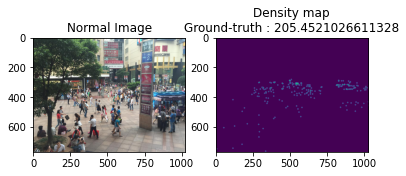

In [ ]:
image_name = "IMG_100"
dataset = "train_data"  # 'test_data'
part = 'part_B' # 'part_A'
prefix = "/content/gdrive/MyDrive/Crowd Computing/ShanghaiTech"

normal_image = img.imread(prefix+'/{}/{}/images/{}.jpg'.format(part,dataset,image_name)) 
plt.subplot(1,2,1)
plt.imshow(normal_image)
# print(normal_image.shape)
plt.title("Normal Image")

f = h5py.File(prefix+'/{}/{}/density_maps/{}.h5'.format(part,dataset,image_name),'r')
plt.subplot(1,2,2)
plt.imshow(np.asarray(f['density']))     # 'bwr'
# print(f['density'].shape)
plt.title("Density map\nGround-truth : {}".format(np.sum(f['density'])))

plt.show()

In [ ]:
image_paths = []
prefix = '/content/gdrive/MyDrive/Crowd Computing/ShanghaiTech'
def create_image_paths():
  part_A_train = os.path.join(prefix,'part_A/train_data','images')
  # part_A_test = os.path.join(prefix,'part_A/test_data','images')
  # part_B_train = os.path.join(prefix,'part_B/train_data','images')
  # part_B_test = os.path.join(prefix,'part_B/test_data','images')
  main_paths = [part_A_train]

  for path in main_paths:
      for image_path in glob.glob(os.path.join(path, '*.jpg')):
          image_paths.append(image_path)
  print("part_A train_data ==>Total images : {}".format(len(image_paths)))

In [ ]:


def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    # print("img :",im.shape)
    # im = np.expand_dims(im,axis  = 0)

    if np.inf in im:
      print("\nim found")
      return np.zeros(im.shape, dtype=np.float32)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    # print('\nh5 :',img.shape)


    img = np.expand_dims(img,axis  = 2)
    # img = np.expand_dims(img,axis  = 0)
    if np.inf in img:
      print("hf found")
      return np.zeros(img.shape, dtype=np.float32)
    return img

In [ ]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [ ]:

def image_generator(files, batch_size):
    print(batch_size)
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','new_density_maps') )

       
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [ ]:

def initialize_weights(model):
    
    # load predefined vgg16 model weights of imagenet dataset
    VGG =  VGG16(weights='imagenet', include_top=False)
    
    VGG_weights=[]                         
    for layer in VGG.layers:
        if('conv' in layer.name):
            VGG_weights.append(layer.get_weights())


    # initialize first 10 frontend layers
    i, skip = 0, 0
    while(i<10):
        if('conv' in model.layers[i+skip].name):
            # print(model.layers[i+skip].name,VGG_weights[i][0].shape,type(VGG_weights[i][0]))
            model.layers[i+skip].set_weights(VGG_weights[i])
            i = i+1  
        else:       # increment skip when pooling layer encounter
            skip = skip + 1        

    # layer - weight shape - weight type 
    # (3, 3, 3, 64) there will be 64 filters of size (3,3,3). For (r, g, b) there will be filter of size (3, 3) 
    # conv2d (3, 3, 3, 64) <class 'numpy.ndarray'>
    # conv2d_1 (3, 3, 64, 64) <class 'numpy.ndarray'>  
    # conv2d_2 (3, 3, 64, 128) <class 'numpy.ndarray'>
    # conv2d_3 (3, 3, 128, 128) <class 'numpy.ndarray'>
    # conv2d_4 (3, 3, 128, 256) <class 'numpy.ndarray'>
    # conv2d_5 (3, 3, 256, 256) <class 'numpy.ndarray'>
    # conv2d_6 (3, 3, 256, 256) <class 'numpy.ndarray'>
    # conv2d_7 (3, 3, 256, 512) <class 'numpy.ndarray'>
    # conv2d_8 (3, 3, 512, 512) <class 'numpy.ndarray'>
    # conv2d_9 (3, 3, 512, 512) <class 'numpy.ndarray'>

    return (model)


def euclidean_distance(yt, yp):

    #   √∑(yt - yp)^2 
    return kb.sqrt(kb.sum(kb.square(yp - yt), axis=-1))    


# Convolutional Neural Network model : first 10 layers of VGG16 + backend
def CSRNet():  

    # Variable Input Size
    rows, cols = None, None
    initializer = RandomNormal(stddev=0.01)
    model = Sequential() 
    
    # custom VGG:
    # frontend of 10 layers
    model.add(Conv2D(64, kernel_size = (3, 3),activation = 'tanh', padding='same',input_shape = (rows, cols, 3), kernel_initializer = initializer))
    model.add(Conv2D(64, kernel_size = (3, 3),activation = 'tanh', padding='same', kernel_initializer = initializer))
    
    model.add(MaxPooling2D(strides=2))
    
    model.add(Conv2D(128,kernel_size = (3, 3), activation = 'tanh', padding='same', kernel_initializer = initializer))
    model.add(Conv2D(128,kernel_size = (3, 3), activation = 'tanh', padding='same', kernel_initializer = initializer))
    
    model.add(MaxPooling2D(strides=2))
    
    model.add(Conv2D(256,kernel_size = (3, 3), activation = 'tanh', padding='same', kernel_initializer = initializer))
    model.add(Conv2D(256,kernel_size = (3, 3), activation = 'tanh', padding='same', kernel_initializer = initializer))
    model.add(Conv2D(256,kernel_size = (3, 3), activation = 'tanh', padding='same', kernel_initializer = initializer))
    
    model.add(MaxPooling2D(strides=2))            
    
    model.add(Conv2D(512, kernel_size = (3, 3),activation = 'tanh', padding='same', kernel_initializer = initializer))
    model.add(Conv2D(512, kernel_size = (3, 3),activation = 'tanh', padding='same', kernel_initializer = initializer))
    model.add(Conv2D(512, kernel_size = (3, 3),activation = 'tanh', padding='same', kernel_initializer = initializer))
        
    # backend of 7 layers with dilation_rate = 2
    model.add(Conv2D(512, (3, 3), activation='tanh', dilation_rate = 2, kernel_initializer = initializer, padding = 'same'))
    model.add(Conv2D(512, (3, 3), activation='tanh', dilation_rate = 2, kernel_initializer = initializer, padding = 'same'))
    model.add(Conv2D(512, (3, 3), activation='tanh', dilation_rate = 2, kernel_initializer = initializer, padding = 'same'))
    model.add(Conv2D(256, (3, 3), activation='tanh', dilation_rate = 2, kernel_initializer = initializer, padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation='tanh', dilation_rate = 2, kernel_initializer = initializer, padding = 'same'))
    model.add(Conv2D(64, (3, 3), activation='tanh', dilation_rate = 2, kernel_initializer = initializer, padding = 'same'))
    model.add(Conv2D(1, (1, 1), activation='tanh', dilation_rate = 1, kernel_initializer = initializer, padding = 'same'))


    # velocity = momentum * velocity - learning_rate * decay
    # w = w + velocity
    sgd = SGD(lr = 0.0005, decay = (5*1e-4), momentum = 0.95)
    # adm = tf.keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.99,epsilon=1e-08,amsgrad=False,name="Adam")
    model.compile(optimizer=sgd, loss=euclidean_distance, metrics=['mse'])
    
    model = initialize_weights(model)
    
    return model


model = CSRNet()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 256)   2

In [ ]:
image_paths.clear()
create_image_paths()
# image_paths = image_paths[:50]

part_A train_data ==>Total images : 300


In [ ]:
train_gen = image_generator(image_paths,64)

In [ ]:
sgd = SGD(lr = 0.0005, decay = (5*1e-4), momentum = 0.95)
adm = tf.keras.optimizers.Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.99,epsilon=1e-08,amsgrad=False,name="Adam")
model.compile(optimizer=sgd, loss=euclidean_distance, metrics=['mse'])

In [ ]:
model.fit_generator(train_gen,epochs=1 ,steps_per_epoch=700, verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


64
379/700 [===============>..............] - ETA: 2:13:22 - loss: 0.0719 - mse: 0.0386

In [ ]:
save_mod(model,"/content/gdrive/MyDrive/Crowd Computing/new_model_A_weights.h5","/content/gdrive/MyDrive/Crowd Computing/new_Model.json")